In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matrixTool import inverse
from scipy.optimize import minimize

In [2]:
def load_data():
    path = 'data/input.data'
    x=[]
    y=[]
    with open(path, 'r') as f:
        for line in f.readlines():
            datapoint = line.split(' ')
            x.append(float(datapoint[0]))
            y.append(float(datapoint[1]))
    x = np.array(x)
    y = np.array(y)
    return x,y

In [3]:
def show(x_line, mean_predict, variance_predict, X, y , alpha=1, l=1):
    plt.figure(figsize=(15,6))
    plt.plot(x_line, mean_predict, 'steelblue', label='mean')
    plt.fill_between(x_line,
                     mean_predict+2*variance_predict,
                     mean_predict-2*variance_predict, 
                     facecolor='powderblue',
                     label='confidence')
    plt.xlim(-60, 60)
    plt.title("alpha={:.2f}, length_scale={:.2f}".format(alpha,l))
    plt.scatter(X, y, c='k', marker='x',  label='data')
    plt.legend(loc='lower left')
    plt.show()

# Part1: 
Apply Gaussian Process Regression to predict the distribution of f and visualize the result

![conditional](img/prediction_new.PNG)

## 1. Rational quadratic kernal
![kernel](img/rational_quadratic_kernal.PNG)

In [4]:
def kernel(Xa, Xb, alpha, l):
    '''
    :param Xa: (n) ndarray
    :param Xb: (m) ndarray
    :return: (n,m)  ndarray
    '''
    square_error = np.power(Xa.reshape(-1,1) - Xb.reshape(1,-1), 2.0)
    kernel = np.power(1 + square_error/(2 * alpha * l ** 2), -alpha)

    return kernel

## 2. Conditional

In [5]:
def predict(x_line, X, y, C, beta, alpha=1, l=1):
    '''
    :param x_line: sampling in linspace(-60,60)
    :param X: (n) ndarray
    :param y: (n) ndarray
    :param C: (n,n) ndarray
    :param beta:
    :return: (len(x_line),1) ndarray, (len(x_line),len(x_line)) ndarray
    '''
    m = len(x_line)
    k_x_xs = kernel(X, x_line, alpha=1, l=1)
    ks     = kernel(x_line, x_line, alpha=1, l=1) + (1 / beta) * np.identity(m)
    
    means     = k_x_xs.T @ inverse(C) @ y.reshape(-1,1)
    variances = ks - k_x_xs.T @ inverse(C) @ k_x_xs

    return means, variances

## 3. Done

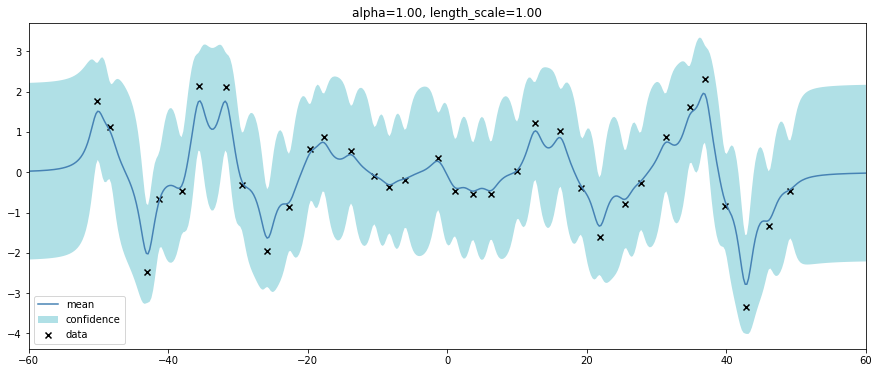

In [26]:
X, y = load_data()
beta = 5
# kernel
C = kernel(X, X, alpha=1, l=1) + 1 / beta * np.identity(len(X))

# mean and variance in range[-60,60]
x_line = np.linspace(-60, 60, num=500)
mean_predict, variance_predict = predict(x_line, X, y, C, beta, alpha=1, l=1)
mean_predict = mean_predict.reshape(-1)
variance_predict = np.sqrt(np.diag(variance_predict))

# plot
show(x_line, mean_predict, variance_predict, X, y, alpha=1, l=1)

# Part2: 
Optimize the kernel parameters by minimizing negative marginal log-likelihood, and visualize the result again.

![kernel](img/optimize_loglikelihood_new.PNG)

In [14]:
# find alpha and l when minimum loglikelihood 
def fun(args):
    '''
    :param args:  X, y, beta
    :return: Optimize alpha, l
    '''
    X, y, beta = args
    y = y.reshape(-1,1)   # y:(n,1)
    def loglikelihood(x0):
        C = kernel(X, X, alpha=x0[0], l=x0[1]) + (1 / beta) * np.identity(len(X))
        v = 0.5 * np.log(np.linalg.det(C)) + \
            0.5 *  (y.T @ inverse(C) @ y) + \
            0.5 * len(X) * np.log(2 * np.pi)
        return v[0]

    return loglikelihood

alpha:  2661.0163609410083
length_scale:  2.9674919139948766


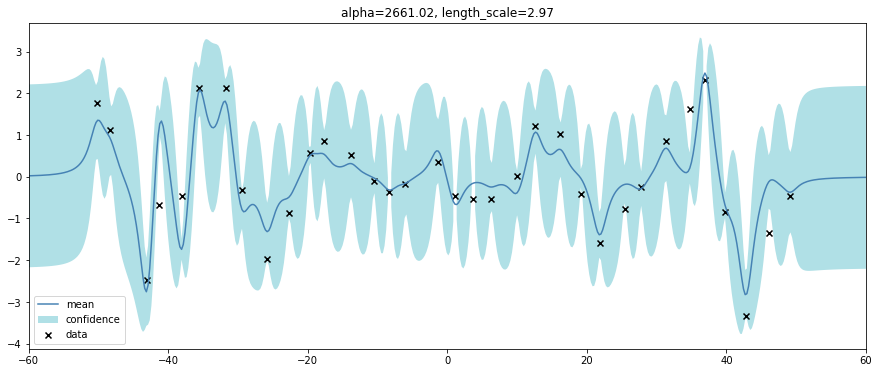

In [15]:
X, y = load_data()
beta = 5

args = (X, y, beta)
objective_value = 1e9
inits = [0.01, 0.1, 0, 10, 100]
for init_alpha in inits:
    for init_length_scale in inits:
        res = minimize(fun = fun(args),
                       x0 = np.asarray([init_alpha, init_length_scale]), 
                       bounds=((1e-5,1e5),(1e-5,1e5)))

        if res.fun < objective_value:
            objective_value = res.fun
            alpha_optimize,length_scale_optimize = res.x
print('alpha: ', alpha_optimize)
print('length_scale: ', length_scale_optimize)

# kernel
C = kernel(X, X, alpha=alpha_optimize, l=length_scale_optimize) + 1 / beta * np.identity(len(X))

# mean and variance in range[-60,60]
x_line = np.linspace(-60, 60, num=500)
mean_predict, variance_predict = predict(x_line, X, y, C, beta, 
                                         alpha=alpha_optimize, 
                                         l=length_scale_optimize)
mean_predict = mean_predict.reshape(-1)
variance_predict = np.sqrt(np.diag(variance_predict))

# plot
show(x_line, mean_predict, variance_predict, X, y,  alpha=alpha_optimize, l=length_scale_optimize)

# Observation

as you increase the length scale, the learnt functions keep getting smoother

as you increase the variance, the scale of values increases.

reference from https://nipunbatra.github.io/blog/ml/2020/06/26/gp-understand.html

In [35]:
# Let y range in (-2,2) more smooth, the length scale will more smaller
y = np.random.uniform(low=-2, high=2, size=(34,))
print(y)

[ 0.86515826 -1.89336714 -1.53333383  1.00507736 -1.76563254 -1.19091002
  1.03768543  1.68925065 -1.39214419  0.2398963   1.34367279 -1.95953392
 -0.26923196  0.21118423 -1.70188557 -1.48248181  1.27770831 -1.70751686
  1.7498574   0.89693675  0.46359653 -0.535761   -0.05758465  0.15120595
  0.72245726 -0.77879245  0.68799101 -0.26873525  1.1096214  -0.68228333
 -0.9085461  -0.03574315  0.60011728 -0.39239231]


alpha:  6.381068146916989
length_scale:  0.009959096534113884


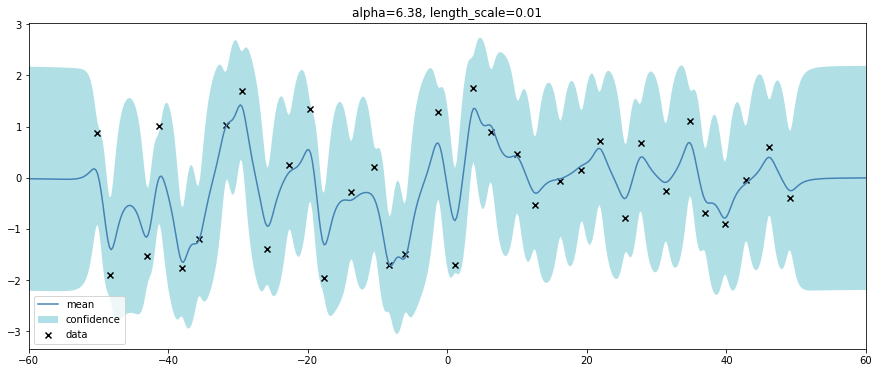

In [36]:
beta = 5

args = (X, y, beta)
objective_value = 1e9
inits = [0.01, 0.1, 0, 10, 100]
for init_alpha in inits:
    for init_length_scale in inits:
        res = minimize(fun = fun(args),
                       x0 = np.asarray([init_alpha, init_length_scale]), 
                       bounds=((1e-5,1e5),(1e-5,1e5)))

        if res.fun < objective_value:
            objective_value = res.fun
            alpha_optimize,length_scale_optimize = res.x
print('alpha: ', alpha_optimize)
print('length_scale: ', length_scale_optimize)

# kernel
C = kernel(X, X, alpha=alpha_optimize, l=length_scale_optimize) + 1 / beta * np.identity(len(X))

# mean and variance in range[-60,60]
x_line = np.linspace(-60, 60, num=500)
mean_predict, variance_predict = predict(x_line, X, y, C, beta, 
                                         alpha=alpha_optimize, 
                                         l=length_scale_optimize)
mean_predict = mean_predict.reshape(-1)
variance_predict = np.sqrt(np.diag(variance_predict))

# plot
show(x_line, mean_predict, variance_predict, X, y,  alpha=alpha_optimize, l=length_scale_optimize)